## Estimación de precio de vivienda en CDMX

In [298]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
pd.options.display.float_format = '{:,.2f}'.format

In [299]:
#Leer datos de precios
precios = pd.read_excel(r'c:\Users\claud\Downloads\precios_vivienda_shf.xlsx', usecols='A:C')
precios.columns=precios.columns.str.lower()
precios.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   año           48 non-null     int64 
 1   trimestre     48 non-null     object
 2   precio_medio  48 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [300]:
#Obtener la media de los precios de manera anual
precios= precios.groupby('año')['precio_medio'].mean().reset_index()
precios['var_precio']=precios['precio_medio'].pct_change()*100
precios

,año,precio_medio,var_precio
0,2019,"3,014,884.50",NaN
1,2020,"2,941,341.75",-2.44
2,2021,"2,977,228.50",1.22
3,2022,"3,197,979.75",7.41
4,2023,"3,698,738.00",15.66
5,2024,"3,892,562.25",5.24
6,2025,"4,135,003.25",6.23
7,2026,"4,377,443.25",5.86
8,2027,"4,619,884.25",5.54
9,2028,"4,862,325.25",5.25


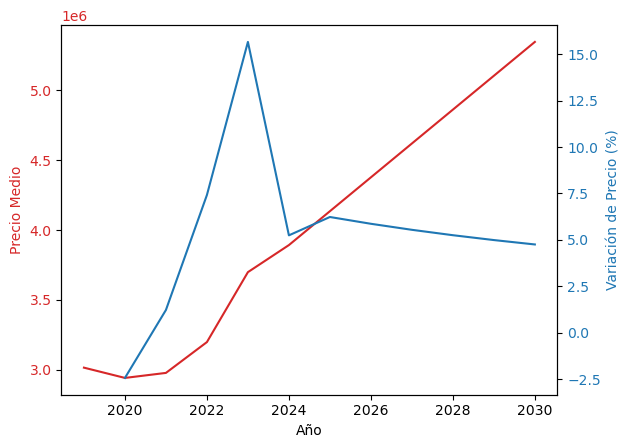

In [301]:
#Graficar precio_medio y var_precio en ejes separados
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Año')
ax1.set_ylabel('Precio Medio', color=color)
ax1.plot(precios['año'], precios['precio_medio'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Variación de Precio (%)', color=color)
ax2.plot(precios['año'], precios['var_precio'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [302]:
# Precio inicial y precio final
precio_inicial = precios['precio_medio'].iloc[0]
precio_final = precios['precio_medio'].iloc[-1]



# Número de años (n)
n = precios.shape[0]-1

# Calcular TCMA
tcmaprecio = (precio_final / precio_inicial) ** (1 / n) - 1
# Convertir a porcentaje
tcmaprecio_percent = tcmaprecio * 100

# Mostrar el resultado
print(f"Tasa de Crecimiento Promedio Anual Precio CDMX 2021-2030: {tcmaprecio_percent:.2f}%")

Tasa de Crecimiento Promedio Anual Precio CDMX 2021-2030: 5.35%


In [303]:
#Calcular variaciones anuales

precios=precios[(precios['año']<=2023) & (precios['año']>=2021)]
precios

,año,precio_medio,var_precio
2,2021,"2,977,228.50",1.22
3,2022,"3,197,979.75",7.41
4,2023,"3,698,738.00",15.66


In [304]:
#Leer datos de vivienda
vivienda = pd.read_excel(r'c:\Users\claud\Downloads\Estimación de vivienda 2021-2030 CDMX por alcaldía.xlsx', usecols='C:M',skiprows=19)
#Dejar solo la primera fila y eliminar las filas restantes
vivienda=pd.DataFrame(vivienda.iloc[0])
vivienda.reset_index(drop=True, inplace=True)
vivienda['año'] = list(range(2020, 2031))
vivienda.columns=['viviendas','año']
#Drop 2020
vivienda=vivienda[vivienda['año']!=2020]
#Calcular var_viviendas
vivienda['var_viviendas']=vivienda['viviendas'].pct_change()*100
vivienda

,viviendas,año,var_viviendas
1,14647,2021,NaN
2,26533,2022,81.15
3,39070,2023,47.25
4,52641,2024,34.74
5,67659,2025,28.53
6,84621,2026,25.07
7,104143,2027,23.07
8,126992,2028,21.94
9,154168,2029,21.40
10,186952,2030,21.27


In [305]:
#Pegar las dos tablas por el año
inicial = pd.merge(vivienda,precios, on='año', how='left')


#Reordenar columna año al inicio
inicial = inicial[['año','viviendas','var_viviendas','precio_medio','var_precio']]
inicial

,año,viviendas,var_viviendas,precio_medio,var_precio
0,2021,14647,NaN,"2,977,228.50",1.22
1,2022,26533,81.15,"3,197,979.75",7.41
2,2023,39070,47.25,"3,698,738.00",15.66
3,2024,52641,34.74,NaN,NaN
4,2025,67659,28.53,NaN,NaN
5,2026,84621,25.07,NaN,NaN
6,2027,104143,23.07,NaN,NaN
7,2028,126992,21.94,NaN,NaN
8,2029,154168,21.40,NaN,NaN
9,2030,186952,21.27,NaN,NaN


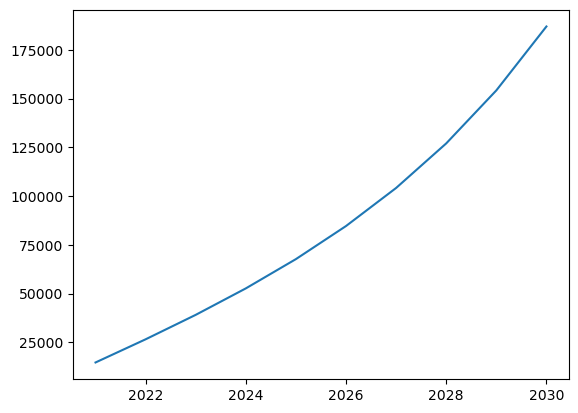

In [306]:
#Grafica variable viviendas
plt.plot(inicial['año'], inicial['viviendas'])

## Función para estimar el crecimiento del precio de la vivienda en CDMX

In [307]:
def calcula_crec_precio(total_viviendas_gob: int):
    """
    Calculate the estimated growth rate of housing prices in CDMX and plot the results.
    
    Args:
        total_viviendas_gob (int): Number of government-provided viviendas to be distributed.
        
    Returns:
        None
    """
    df = inicial.copy()
   
    # Number of years over which to distribute the viviendas
    num_años_repartir = 10

    # Indexes of the last N years where the viviendas will be distributed
    años_a_distribuir = df.tail(num_años_repartir).index
    viviendas_gobierno_por_año = total_viviendas_gob // num_años_repartir

    # Create the viviendas_gobierno column
    df['viviendas_gobierno'] = 0
    df.loc[años_a_distribuir, 'viviendas_gobierno'] = viviendas_gobierno_por_año

    # Ensure the total matches exactly
    viviendas_gobierno_restantes = total_viviendas_gob - (viviendas_gobierno_por_año * num_años_repartir)
    df.loc[años_a_distribuir[-1], 'viviendas_gobierno'] += viviendas_gobierno_restantes

    # Calculate the total viviendas
    df['viviendas_congob'] = df['viviendas'] + df['viviendas_gobierno']
    df['var_viviendas_congob'] = df['viviendas_congob'].pct_change() * 100

    # Train the model
    known = df[df['precio_medio'].notna()]
    X_train = known[['var_viviendas_congob']]
    y_train = known['precio_medio']
    X_train = X_train.fillna(X_train.mean())
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict unknown values
    unknown = df[df['precio_medio'].isna()]
    X_test = unknown[['var_viviendas_congob']].fillna(X_train.mean())
    df.loc[df['precio_medio'].isna(), 'precio_medio'] = model.predict(X_test)
    df['var_precio'] = df['precio_medio'].pct_change() * 100

    # Calculate TCMA
    precio_inicial = df['precio_medio'].iloc[0]
    precio_final = df['precio_medio'].iloc[-1]
    n = df.shape[0] - 1

    tcmaprecio = ((precio_final / precio_inicial) ** (1 / n) - 1) * 100

    # Plot the results
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Año')
    ax1.set_ylabel('Precio Medio', color=color)
    ax1.plot(df['año'], df['precio_medio'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Variación de Precio (%)', color=color)
    ax2.plot(df['año'], df['var_precio'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f"Tasa de Crecimiento Promedio Anual Precio CDMX 2021-2030: {tcmaprecio:.2f}% con una intervención de {df['viviendas_gobierno'].sum()} viviendas del GOBCDMX")
    plt.grid()
    fig.tight_layout()
    plt.show()
    
    return df

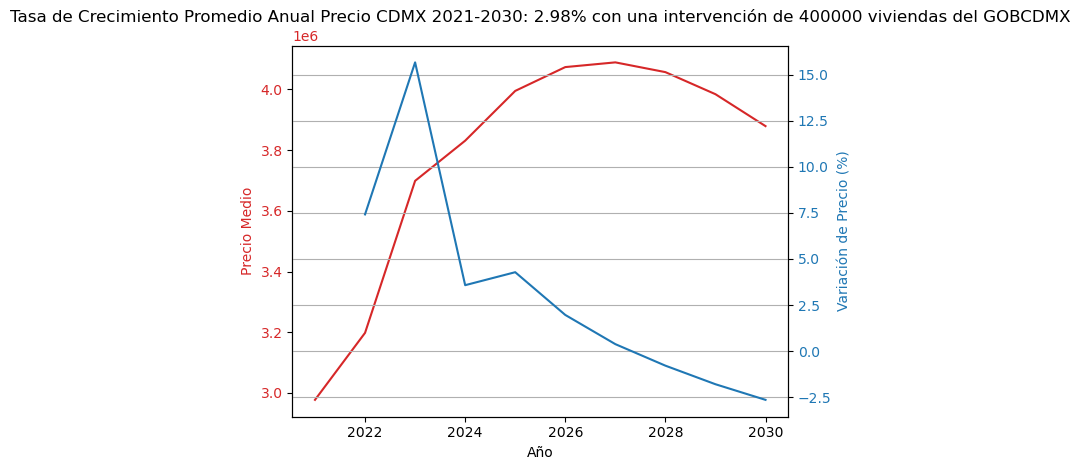

,año,viviendas,var_viviendas,precio_medio,var_precio,viviendas_gobierno,viviendas_congob,var_viviendas_congob
0,2021,14647,NaN,"2,977,228.50",NaN,40000,54647,NaN
1,2022,26533,81.15,"3,197,979.75",7.41,40000,66533,21.75
2,2023,39070,47.25,"3,698,738.00",15.66,40000,79070,18.84
3,2024,52641,34.74,"3,831,069.17",3.58,40000,92641,17.16
4,2025,67659,28.53,"3,995,100.44",4.28,40000,107659,16.21
5,2026,84621,25.07,"4,073,586.65",1.96,40000,124621,15.76
6,2027,104143,23.07,"4,089,124.08",0.38,40000,144143,15.67
7,2028,126992,21.94,"4,056,996.24",-0.79,40000,166992,15.85
8,2029,154168,21.40,"3,984,271.58",-1.79,40000,194168,16.27
9,2030,186952,21.27,"3,879,112.97",-2.64,40000,226952,16.88


In [308]:
calcula_crec_precio(400000)

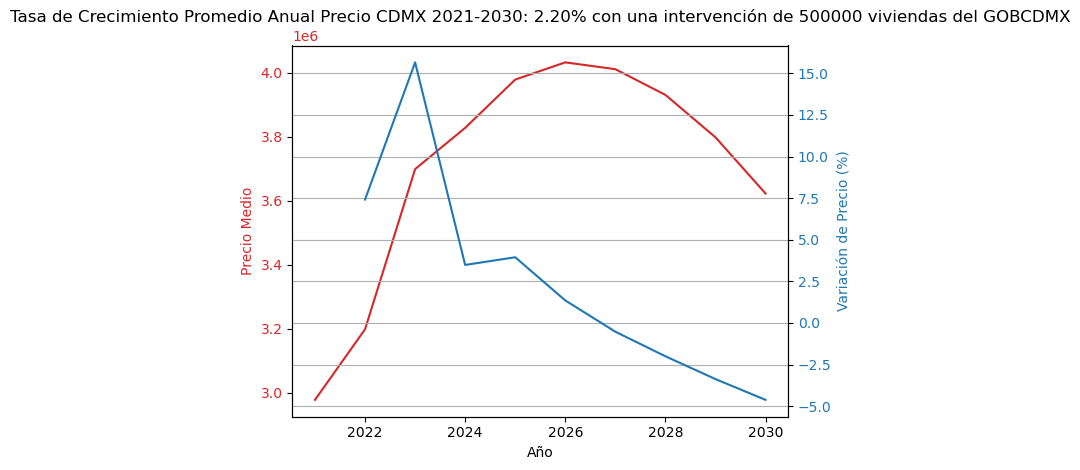

,año,viviendas,var_viviendas,precio_medio,var_precio,viviendas_gobierno,viviendas_congob,var_viviendas_congob
0,2021,14647,NaN,"2,977,228.50",NaN,50000,64647,NaN
1,2022,26533,81.15,"3,197,979.75",7.41,50000,76533,18.39
2,2023,39070,47.25,"3,698,738.00",15.66,50000,89070,16.38
3,2024,52641,34.74,"3,827,646.76",3.49,50000,102641,15.24
4,2025,67659,28.53,"3,978,698.61",3.95,50000,117659,14.63
5,2026,84621,25.07,"4,032,486.03",1.35,50000,134621,14.42
6,2027,104143,23.07,"4,011,201.31",-0.53,50000,154143,14.50
7,2028,126992,21.94,"3,930,824.54",-2.00,50000,176992,14.82
8,2029,154168,21.40,"3,798,164.45",-3.37,50000,204168,15.35
9,2030,186952,21.27,"3,622,572.87",-4.62,50000,236952,16.06


In [329]:
calcula_crec_precio(500000)